# 17) Householder QR

## Last time

* Gram-Schmidt orthogonalization
* Classical vs Modified Gram-Schmidt
* QR factorization

## Today

1. Recap from last time
2. Householder QR  

In [2]:
using LinearAlgebra
using Plots
using Polynomials
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

## 1. Recap Gram-Schmidt orthogonalization



For many applications, we find ourselves interested in the column spaces of a matrix $A$:

$$
\langle a_1 \rangle  \subseteq \langle a_1, a_2 \rangle \subseteq \langle a_1, a_2, a_3 \rangle \ldots 
$$

The idea of QR factorization is the construction of a sequence of orthonormal vectors, $q_1, q_2, \ldots$ that span these successive spaces.

Thus, suppose we want to find an orthogonal basis for the span of the columns of $A$:

$$ \Bigg[ a_1 \Bigg| a_2 \Bigg] = \Bigg[ q_1 \Bigg| q_2 \Bigg] \begin{bmatrix} r_{11} & r_{12} \\ 0 & r_{22} \end{bmatrix} $$

Given $a_1, a_2, \dots$, we can construct vectors $q_1, q_2, \ldots$ and entries $r_{ij}$, by an iterative process of successive orthogonalization.



### Gram-Schmidt with more parallelism

\begin{align}
(I - q_2 q_2^T) (I - q_1 q_1^T) v &= (I - q_1 q_1^T - q_2 q_2^T + q_2 q_2^T q_1 q_1^T) v \\
&= \Bigg( I - \Big[ q_1 \Big| q_2 \Big] \begin{bmatrix} q_1^T \\ q_2^T \end{bmatrix} \Bigg) v
\end{align}

In [2]:
function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

In [3]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_classical(A)
@show norm(Q' * Q - I) # really not orthogonal; unstable algorithm
@show norm(Q * R - A)

norm(Q' * Q - I) = 1.4985231287367549
norm(Q * R - A) = 7.350692433565389e-16


7.350692433565389e-16

### Right-looking modified Gram-Schmidt

Each outer step of the modified Gram-Schmidt algorithm can be interpreted as a right-multiplication by a square upper-triangular matrix.

In [6]:
function gram_schmidt_modified(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(n, n)
    for j in 1:n
        R[j,j] = norm(Q[:,j])
        Q[:,j] /= R[j,j]
        R[j,j+1:end] = Q[:,j]'*Q[:,j+1:end]
        Q[:,j+1:end] -= Q[:,j]*R[j,j+1:end]'
    end
    Q, R
end

gram_schmidt_modified (generic function with 1 method)

In [7]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_modified(A)
@show norm(Q' * Q - I) # better, in terms of orthogonality error
@show norm(Q * R - A)

norm(Q' * Q - I) = 8.486718528276085e-9
norm(Q * R - A) = 8.709998074379606e-16


8.709998074379606e-16

### Classical versus modified?

* Classical
  * Really unstable, orthogonality error of size $1 \gg \epsilon_{\text{machine}}$
  * Don't need to know all the vectors in advance
* Modified
  * Needs to be right-looking for efficiency
  * Less unstable, but orthogonality error $10^{-9} \gg \epsilon_{\text{machine}}$

In [8]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = qr(A)
@show norm(Q' * Q - I)

norm(Q' * Q - I) = 3.216006485393791e-15


3.216006485393791e-15

## 2. Householder triangularization

Householder triangularization is numerically more stable than Gram-Schmidt orthogonaliztion, though it lacks the latter's applicability as a basis for iterative methods. The Householder algorithm is a process of "orthogonal triangularization", making a matrix triangular by a sequence of unitary matrix operations.

Gram-Schmidt constructed a triangular matrix $R$ to orthogonalize $A$ into $Q$. Each step was an orthogonal _projector_, which is a rank-deficient operation. 

![Oblique projector (Trefethen and Bau, 1999)](../img/TB-oblique-projector.png)

![Orthogonal projector (Trefethen and Bau, 1999)](../img/TB-orthogonal-projector.png)



Householder uses orthogonal transformations (_reflectors_) to triangularize.

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

![Householder Reflector (Trefethen and Bau, 1999)](../img/TB-Householder.png)

The reflection, as depicted above by Trefethen and Bau (1999) can be written $F = I - 2 \frac{v v^T}{v^T v}$.

The structure of the algorithm is

$$ \underbrace{\begin{bmatrix} * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ \end{bmatrix}}_{A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ \end{bmatrix}}_{Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & * \\ 0 & 0 & * \\ \end{bmatrix}}_{Q_2 Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ \end{bmatrix}}_{Q_3 Q_2 Q_1 A}
$$

### Constructing the $Q_j$

$$ \underbrace{Q_{n-1} \dotsb Q_0}_{Q^T} A = R $$

Each of our $Q_j$ will have the form
$$Q_j = \begin{bmatrix} I_j & 0 \\ 0 & F \end{bmatrix}$$
where $F$ is a "reflection" that achieves
$$ F x = \begin{bmatrix} \lVert x \rVert \\ 0 \\ 0 \\ \vdots \end{bmatrix} $$
where $x$ is the column of $R$ from the diagonal down.
This transformation is a _reflection_ across a plane with normal $v = Fx - x = \lVert x \rVert e_1 - x$.

The two methods can be summarized as follows:
- Gram-Schmidt: a triangular orthogonalization
- Householder: an orthogonal triangularization

### Adventures in reflection

In [4]:
A = rand(4, 4); A += A'
v = copy(A[:,1])
@show norm(v)
v[1] -= norm(v)
v = normalize(v)
F = I - 2 * v * v'
B = F * A # we have zeroed-out all entries below the diagonal in the first column

norm(v) = 2.719617403538663


4×4 Matrix{Float64}:
  2.71962       2.44281     1.59937    1.76917
 -1.78416e-16  -0.0845984  -0.891346  -0.714971
  4.95012e-17  -0.0274252   0.730279   0.128388
  2.089e-17    -0.961306   -0.658574   0.241872

In [7]:
v = copy(B[2:end, 2])
v[1] -= norm(v)
v = normalize(v)
F = I - 2 * v * v'
B[2:end, 2:end] = F * B[2:end, 2:end] # we have zeroed-out all entries below the diagonal also in the 2nd column
B

4×4 Matrix{Float64}:
  2.71962       2.44281      1.59937    1.76917
 -1.78416e-16   0.965411     0.713136  -0.181838
  4.95012e-17   3.46945e-18  0.772187   0.142313
  2.089e-17    -1.11022e-16  0.810363   0.729966

### Householder: A naive algorithm

In [8]:
function qr_householder_naive(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] -= norm(v)
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * (v' * R[j:end,j:end])
        push!(V, v)
    end
    V, R
end

qr_householder_naive (generic function with 1 method)

In [9]:
m = 4
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
_, R_ = qr(A)
R_

4×4 Matrix{Float64}:
 -2.0  0.0      -1.11111      0.0
  0.0  1.49071   1.38778e-17  1.3582
  0.0  0.0       0.888889     9.71445e-17
  0.0  0.0       0.0          0.397523

### How to interpret $V$ as $Q$?

In [10]:
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

function reflectors_to_dense(V)
    m = length(V[1])
    Q = diagm(ones(m))
    for j in 1:m
        Q[:,j] = reflectors_mult(V, Q[:,j])
    end
    Q
end

reflectors_to_dense (generic function with 1 method)

In [13]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 3.7994490775439526e-15
norm(Q * R - A) = 7.562760794606217e-15


### Great, but we can still break it

In [15]:
A = [1. 0; 0 1.]
V, R = qr_householder_naive(A)

(Any[[NaN, NaN], [NaN]], [NaN NaN; NaN NaN])

We had the lines

```julia
    v = copy(R[j:end, j])
    v[1] -= norm(v)
    v = normalize(v)
```
What happens when `R` is already upper triangular?

![Choosing the better of two Householder reflectors (Trefethen and Bau, 1999).](../img/TB-Householder2reflectors.png)

Two possible reflections. For numerical stability, it is important to choose the one that moves $x$ the largest distance, so that it is not too close to $x$ itself.

In fact, suppose that in the above figure, angle of $H^{+}$ and the $e_1$ axis is much smaller than $x$ or $|| x || e_1$. Thus, the calculation of $v$ represents a subtraction of nearby quantities and will tend to suffer from cancellation errors. We can pick the sign of $v$ so that we can avoid such effects by ensuring that $||v||$ is never smaller than $||x||$.

### Householder: An improved algorithm



In [16]:
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

In [17]:
A = [2 -1; -1 2] * 1e-10
A = [1 0; 0 1]
V, R = qr_householder(A)
tau = [2*v[1]^2 for v in V]
@show tau
V1 = [v ./ v[1] for v in V]
@show V1
R

tau = [2.0, 2.0]
V1 = [[1.0, 0.0], [1.0]]


2×2 Matrix{Int64}:
 -1   0
  0  -1

### Householder is backward stable

In [18]:
m = 40
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 5.949301496893686e-15
norm(Q * R - A) = 1.2090264267288813e-14


In [19]:
A = [1 0; 0 1.]
V, R = qr_householder(A)
qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor:
2×2 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}:
 1.0  0.0
 0.0  1.0
R factor:
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

### Orthogonality is preserved

norm(v) = 1.4245900685395503


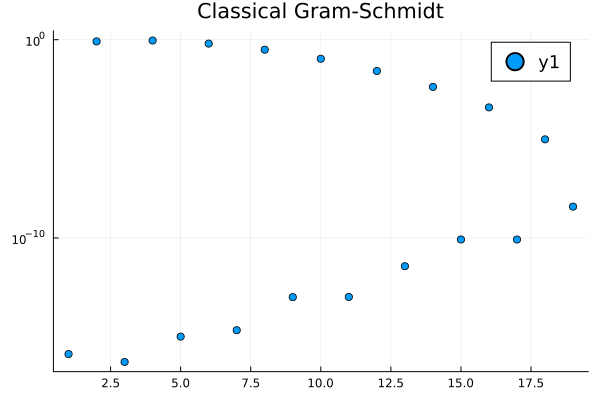

In [20]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, _ = gram_schmidt_classical(A)
v = A[:,end]
@show norm(v)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Classical Gram-Schmidt")

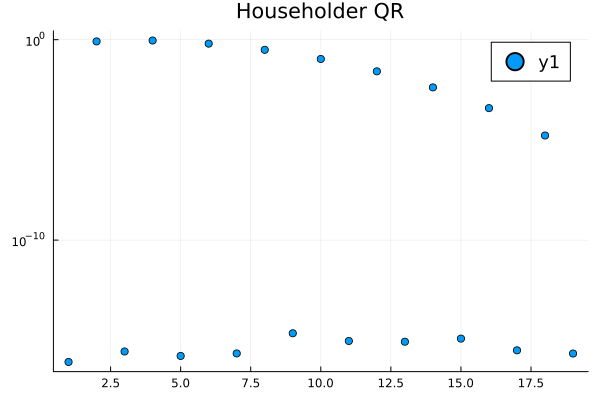

In [21]:
Q = reflectors_to_dense(qr_householder(A)[1])
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Householder QR")